# _Python for Scientific Data Analysis_


#  AstroPy and AstroQuery

## Section 3b: URL Queries

In the previous lecture, we explored ``astroquery``, a powerful tool for querying astronomical databases like SIMBAD and Vizier. 

While powerful, astroquery is (obviously) very astronomy specific and a lot of what it does is very much under the hood and hidden from the user.

Scientists often find themselves in more general cases of having to pull data from databases or one of many other wide variety of sources from the web.  E.g. satellite tracking information, custom web services developed by collaborations, things hosted on Github repositories, etc. For these cases, we need more general tools to access data from the web.

The libraries for more general URL queries are Python's ``urllib`` and ``requests``.  

 These libraries allow you to interact with any web-based data source—whether it's a CSV file hosted on GitHub, a Javascript Object Notation (JSON) API, etc.  ``astroquery`` is very astronomy specific while ``urllib`` and ``requests`` are general-purpose libraries for web data access.
 
Here, we will cover a few topics:

* Fetch data directly from URLs using urllib
* Parse different data formats (CSV, JSON, XML)
* Handle common challenges like authentication and error handling

While there will be alternate ways of working with such data using native Python functions, astropy provides a lot of shortcuts that may be useful.


### Set Up
The basic setup for URL fetch commands involve importing ``request`` from ``urllib``, modules dealing with errors with URL queries and parsing the queries, dealing with different file types, displaying images.  If we want to use ``requests`` then we have to import it as well.


In [2]:
#standard
import numpy as np
import matplotlib.pyplot as plt

#for URLLIB
# Import required libraries
from urllib import request
import urllib.error
import urllib.parse

#other useful stuff
import json #for parsing JSON
import csv #for reading/writing csv files natively within python ... astropy can do this too
import xml.etree.ElementTree as ET #for parsing XML data

#other useful stuff for reading in images and then displaying
from PIL import Image
from io import BytesIO

#for REQUESTS
import requests #note: if you dont' have requests, you will need to pip install requests

In [3]:
#also import astropy
from astropy.io import ascii

We will start with a simple example: pulling an archival Astronomy Picture of the Day (Nov 17 2025) from the web

### A Simple Example: Scraping Image Files

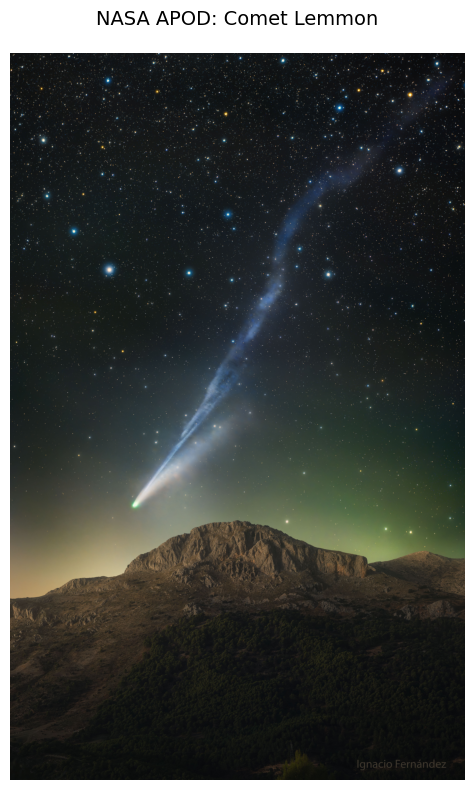

In [4]:
#super simple version: you already know the URL which points directly to a figure file 
#and are just accessing the image

url="https://apod.nasa.gov/apod/image/2511/LemmonTail_Fernandez_3728.jpg"

data=request.urlopen(url)


# Download the image using urllib
#with urllib.request.urlopen(url) as response:
#    image_data = response.read()

image_data=data.read()

image = Image.open(BytesIO(image_data))

# Convert bytes to image
#image = mpimg.imread(BytesIO(image_data), format='jpg')

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title('NASA APOD: Comet Lemmon', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Now, the above was kind of cheating: I was pointing directly to the image file.  What if the image is embedded in an html (i.e. what if you are trying to 'scrap' an image from a URL?)

<re.Match object; span=(1118, 1168), match='<a href="image/2511/LemmonTail_Fernandez_3728.jpg>
Found image URL: https://apod.nasa.gov/apod/image/2511/LemmonTail_Fernandez_3728.jpg


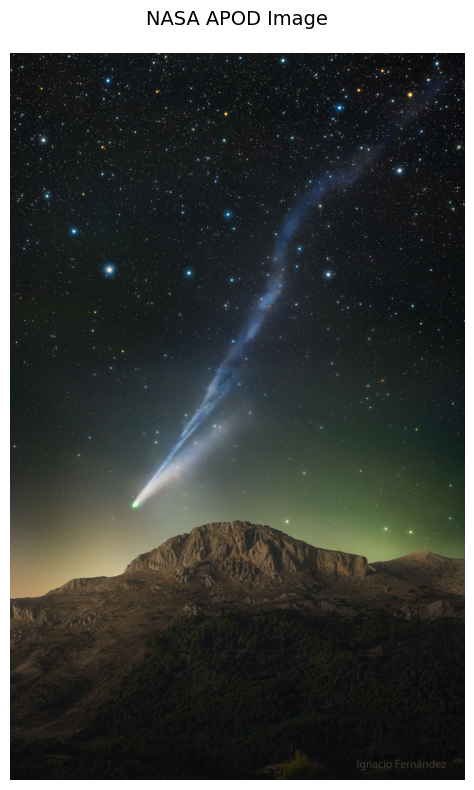

In [6]:
#slightly more complicated: we are pulling a file from an HTML page
import re #regular expression matching ... remember this?


# URL of the HTML page
html_url = "https://apod.nasa.gov/apod/ap251117.html"

#with request.urlopen(html_url) as response:
#    html_content = response.read().decode('utf-8')

#or
image_data=(request.urlopen(html_url).read()).decode('utf-8')

# Find the image URL using regex
# Look for <a href="image/..."> pattern which is typical for APOD
image_pattern = r'<a href="(image/[^"]+\.jpg)"'
match = re.search(image_pattern, image_data, re.IGNORECASE)

print(match) #we have a match!

if match:
    # Extract the relative image path
    relative_image_path = match.group(1)
    
    # Construct the full image URL
    base_url = "https://apod.nasa.gov/apod/"
    image_url = urllib.parse.urljoin(base_url, relative_image_path)
    
    #print(f"Found image URL: {image_url}")
    print("Found image URL: {0:s}".format(image_url))
    
    # Download the image
    with urllib.request.urlopen(image_url) as img_response:
        image_data = img_response.read()
    
    # Convert bytes to image
    image = Image.open(BytesIO(image_data))
    #image = mpimg.imread(BytesIO(image_data), format='jpg')
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title('NASA APOD Image', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("Could not find image link in the HTML page")

Now, the above looks a bit ugly and maybe you don't like to do regular expression matching.  For you, there is BeautifulSoup .  The result is the same and if this html page didn't have so many hyperlinks it would be fewer lines of code.

the href is archivepix.html
the href is image/2511/LemmonTail_Fernandez_3728.jpg
Found image URL: https://apod.nasa.gov/apod/image/2511/LemmonTail_Fernandez_3728.jpg


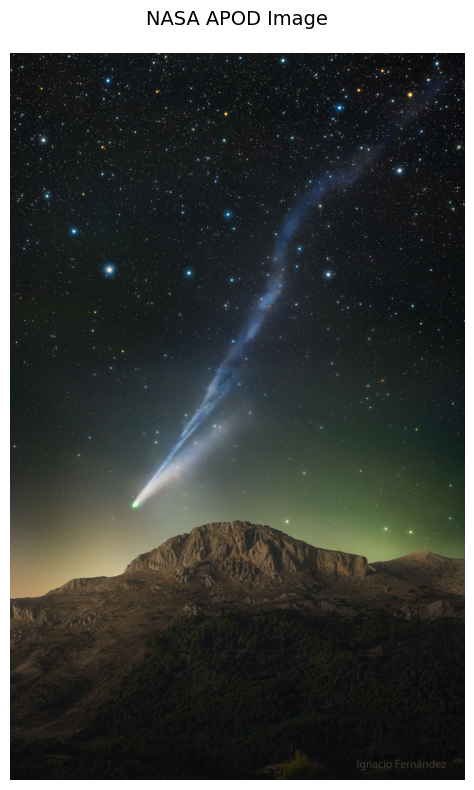

In [7]:
from bs4 import BeautifulSoup

# URL of the HTML page
html_url = "https://apod.nasa.gov/apod/ap251117.html"

#with request.urlopen(html_url) as response:
#    html_content = response.read().decode('utf-8')

#or
image_data=(request.urlopen(html_url).read()).decode('utf-8')

# Parse HTML with BeautifulSoup
soup = BeautifulSoup(image_data, 'html.parser')

# Find all the hyperlinks
# Find the first <a> tag that links to an image

for link in soup.find_all('a', href=True):
    href = link['href']
    print('the href is',href)
    #if the hyperlink contains ``image" and ends with an image file type ....
    if 'image/' in href and (href.endswith('.jpg') or href.endswith('.png') or href.endswith('.gif')):
        relative_image_path = href
        break
        
#note the two hrefs: this is why we couldn't do img_link = soup.find('a', href=True)

# Construct the full image URL
base_url = "https://apod.nasa.gov/apod/"
image_url = urllib.parse.urljoin(base_url, relative_image_path)

print(f"Found image URL: {image_url}")
# Download the image
with request.urlopen(image_url) as img_response:
    image_data = img_response.read()

    # Convert bytes to image
image = Image.open(BytesIO(image_data))

    # Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title('NASA APOD Image', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Here's an example where we can scrape an image file with ``requests`` and then save it locally...

In [8]:
#import requests

image_url = "https://apod.nasa.gov/apod/image/1901/IC405_Abolfath_3171.jpg"
response = requests.get(image_url)

f=open("nebula.jpg","wb")
f.write(response.content)

#with open("nebula.jpg", "wb") as f:
#    f.write(response.content)

print("Image saved as nebula.jpg")

Image saved as nebula.jpg


### Pulling Files from the Internet and Using Them

Great, so we can pull/scrape images.   Let's do something more scientifically useful, like pull data from tables.  Here is a csv table showing data from the 2014 Ebola virus outbreak...

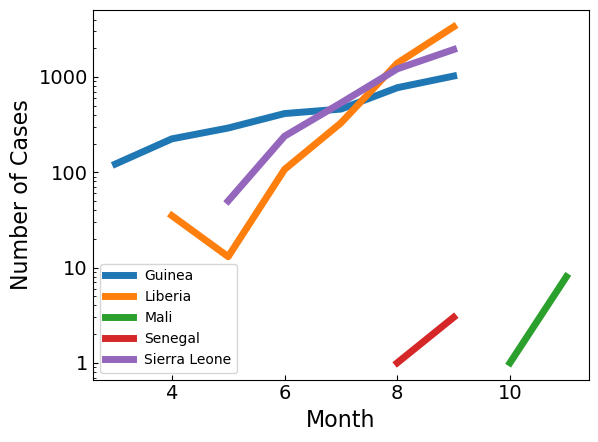

In [9]:
url = "https://raw.githubusercontent.com/plotly/datasets/master/2014_ebola.csv"


from matplotlib.ticker import FormatStrFormatter

thedata=(request.urlopen(url)).read().decode('utf-8')
thetable=ascii.read(thedata,format='csv')
thetable

countries=thetable['Country']
values=thetable['Value']
month=thetable['Month']


#print(np.unique(countries))
countrylist=np.unique(countries)
#now plot this up

colors=['tab:blue','tab:green','orange','magenta']
fig,ax=plt.subplots()
for i in range(len(countrylist)):
 ax.plot(month[countries==countrylist[i]],values[countries==countrylist[i]],label='{0:s}'.format(countrylist[i]),lw=5)

ax.set_yscale('log')
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.tick_params('both',labelsize=14)
ax.tick_params(which='both',axis='both',direction='in')
ax.set_ylabel('Number of Cases',fontsize=16)
ax.set_xlabel('Month',fontsize=16)
ax.legend()
plt.show()


### Fetching JSON Data

In [10]:
# Example: Fetch exoplanet data from NASA Exoplanet Archive

# (This is a simple query for planets around stars with Teff > 5000K)
json_url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,hostname,pl_bmasse,pl_orbper+from+ps+where+st_teff>5000+and+pl_bmasse+is+not+null&format=json"

with request.urlopen(json_url) as response:
    exoplanet_data = json.load(response)

print(f"Found {len(exoplanet_data)} planets")
print("\nFirst 3 planets:",exoplanet_data[0:3])
print('')
##print("all the data",exoplanet_data)
#exoplanet_data

from astropy.table import Table #watch this!

# Convert JSON data to Astropy Table
exoplanet_table = Table(exoplanet_data)

#a=ascii.read(exoplanet_data)

exoplanet_table

Found 3464 planets

First 3 planets: [{'pl_name': 'Kepler-6 b', 'hostname': 'Kepler-6', 'pl_bmasse': 212.31044, 'pl_orbper': 3.2346996}, {'pl_name': 'Kepler-6 b', 'hostname': 'Kepler-6', 'pl_bmasse': 201.18639, 'pl_orbper': 3.234702}, {'pl_name': 'Kepler-6 b', 'hostname': 'Kepler-6', 'pl_bmasse': 205.63601, 'pl_orbper': 3.2346994}]



pl_name,hostname,pl_bmasse,pl_orbper
str25,str23,float64,object
Kepler-6 b,Kepler-6,212.31044,3.2346996
Kepler-6 b,Kepler-6,201.18639,3.234702
Kepler-6 b,Kepler-6,205.63601,3.2346994
Kepler-6 b,Kepler-6,212.619,3.234723
Kepler-29 c,Kepler-29,4.0,13.2884
Kepler-29 c,Kepler-29,95.3,13.2907
Kepler-29 c,Kepler-29,4.5,13.28613
Kepler-20 c,Kepler-20,11.1,10.8540774
Kepler-20 c,Kepler-20,12.75,10.85409089


### Fetching XML Data

XML is another common data format, especially for older astronomical databases and NASA data services.  It stands for eXtensible Markup Language.


In [11]:
# We'll use a simple XML file for demonstration
xml_url = "https://www.w3schools.com/xml/note.xml"
#xml_url = "http://www.w3.org/1999/xlink"

with request.urlopen(xml_url) as response:
    xml_data = response.read()

# Parse XML
root = ET.fromstring(xml_data)
print(xml_data)
# Extract information
print("XML Structure:")
for child in root:
    print(f"  {child.tag}: {child.text}")

b'<?xml version="1.0" encoding="UTF-8"?>\n<note>\n  <to>Tove</to>\n  <from>Jani</from>\n  <heading>Reminder</heading>\n  <body>Don\'t forget me this weekend!</body>\n</note>'
XML Structure:
  to: Tove
  from: Jani
  heading: Reminder
  body: Don't forget me this weekend!


## Error Handling

In [12]:
# %%
def fetch_with_urllib(url):
    """Fetch URL with proper error handling"""
    try:
        with request.urlopen(url, timeout=10) as response:
            return response.read().decode('utf-8')
    except urllib.error.HTTPError as e:
        print(f"HTTP Error {e.code}: {e.reason}")
        return None
    except urllib.error.URLError as e:
        print(f"URL Error: {e.reason}")
        return None
    except TimeoutError:
        print("Request timed out")
        return None

# Test with a valid URL
good_url = "https://raw.githubusercontent.com/plotly/datasets/master/2014_ebola.csv"
data = fetch_with_urllib(good_url)
if data:
    print('Good URL')
    print("Successfully fetched data")
    print('Data Length {0:d} characters'.format(len(data)))
    print('')
#and now with a recently missing URL

# Fetch 10 most recent COVID-19 clinical trials
bad_url = "https://clinicaltrials.gov/api/query/study_fields"
params = {
    "expr": "COVID-19",
    "fields": "NCTId,Condition,BriefTitle,StudyType,Phase",
    "min_rnk": 1,
    "max_rnk": 10,
    "fmt": "JSON"
}

data = fetch_with_urllib(bad_url)

if not data:
    print('Bad URL')

Good URL
Successfully fetched data
Data Length 899 characters

HTTP Error 404: Not Found
Bad URL


In [13]:
###  Error Handling with requests (more robust)

# %%
def fetch_with_requests(url, timeout=10):
    """Fetch URL with comprehensive error handling"""
    try:
        response = requests.get(url, timeout=timeout)
        
        # Raise exception for bad status codes (4xx, 5xx)
        response.raise_for_status()
        
        return response
        
    except requests.exceptions.HTTPError as e:
        print(f"HTTP Error: {e}")
        print(f"  Status code: {response.status_code}")
        return None
    except requests.exceptions.ConnectionError:
        print("Connection Error: Failed to connect to server")
        return None
    except requests.exceptions.Timeout:
        print("Timeout Error: Request took too long")
        return None
    except requests.exceptions.RequestException as e:
        print(f"Request Error: {e}")
        return None

# Test with various URLs
print("Test 1: Valid URL")
response = fetch_with_requests("https://api.github.com/repos/astropy/astropy")
if response:
    print(f"  ✓ Success! Status: {response.status_code}")

print("\nTest 2: 404 Error")
response = fetch_with_requests("https://api.github.com/repos/fake/repository")
response = fetch_with_requests("https://clinicaltrials.gov/api/query/study_fields")

print("\nTest 3: Timeout (should take 2 seconds)")
response = fetch_with_requests("https://httpbin.org/delay/10", timeout=2)

Test 1: Valid URL
  ✓ Success! Status: 200

Test 2: 404 Error
HTTP Error: 404 Client Error: Not Found for url: https://api.github.com/repos/fake/repository
  Status code: 404
HTTP Error: 404 Client Error: Not Found for url: https://clinicaltrials.gov/api/query/study_fields
  Status code: 404

Test 3: Timeout (should take 2 seconds)
Timeout Error: Request took too long
